In [1]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt

g, m , rho, Vb, veq = sp.symbols('g m rho V_b V_eq')

v, vc, y, ym, th, th1, th2, B, p, a, b, e, gamma = sp.symbols('v v_c y y_m theta theta_1 theta_2 B p a b e gamma')
u, uc, zeta, omega = sp.symbols('u u_c zeta omega')

In [16]:
y_u = B*u/(p**2+p*B)
ym_uc = (omega**2)*uc/(p**2+2*zeta*omega*p+omega**2)

u_u = th1*(y-uc)-th2*p*y

y_uc = -B*th1*uc/(p**2+p*(B+B*th2)-B*th1)
error = y_uc - ym_uc

uc_y = (p**2+p*(B+B*th2)-B*th1)*y/(-B*th1)
uc_ym = (p**2+2*zeta*omega*p+omega**2)*ym/(omega**2)


In [30]:
de_th1 = sp.diff(error,th1).simplify()
de_th1

-B*p*u_c*(B*(theta_2 + 1) + p)/(B*p*(theta_2 + 1) - B*theta_1 + p**2)**2

In [21]:
de_th2 = sp.diff(error,th2).simplify()
de_th2

B**2*p*theta_1*u_c/(B*p*(theta_2 + 1) - B*theta_1 + p**2)**2

In [25]:
de_th1.subs(uc, uc_y).simplify()

p*y*(B*(theta_2 + 1) + p)/(theta_1*(B*p*(theta_2 + 1) - B*theta_1 + p**2))

In [27]:
de_th2.subs(uc, uc_y).simplify()

-B*p*y/(B*p*(theta_2 + 1) - B*theta_1 + p**2)

In [28]:
error

-B*theta_1*u_c/(-B*theta_1 + p**2 + p*(B*theta_2 + B)) - omega**2*u_c/(omega**2 + 2*omega*p*zeta + p**2)

In [2]:
#constants 
ZETA = 1
OMEGA = 1

#
radius = 38/1000
g = 9.8
m = 4/7000
rho = 1.225
Vb = (4/3)*np.pi*(radius**3)
v_eq=2.8
B = 2*g*(m-rho*Vb)/(m*v_eq)
#B=2

#adaptation law
GAMMA = 0.5
alpha = 0.75
#simulation params
ts = 0.2
maxt = 90
n_steps = int(maxt/ts)

def u_signal(t):
    function_val = np.sin(np.pi*t/15)
    if function_val >= 0:
        result = 0.1
    else:
        result = 0.2
    return result

def system_model(uc_i, ym_p1_i, ym_i):
    ym_p2_o = (OMEGA**2)*uc_i - 2*ZETA*OMEGA*ym_p1_i - (OMEGA**2)*ym_i
    ym_p1_o = ym_p1_i + ts*ym_p2_o
    ym_o = ym_i + ts*ym_p1_o
    
    system_model_dict = {"ym_p2":ym_p2_o,
                          "ym_p1":ym_p1_o,
                          "ym":ym_o}
    return system_model_dict

def system_sim(y_p1_i,y_i,u_i):
    y_p2_o = B*u_i - B*y_p1_i
    
    y_p1_o = y_p1_i + ts*y_p2_o
    
    y_o = y_i + ts*y_p1_o + np.random.normal(0.0, 0.001)
    
    system_dict = {"y_p2":y_p2_o,
                "y_p1": y_p1_o,
                  "y": y_o}
    
    return system_dict
def controller(y_i, uc_i, y_p1_i, th1, th2):
    control_signal = th1*(y_i - uc_i) - th2*y_p1_i
    return control_signal

def Adaptation_Law_Model(y_i, ym_i, ym_p1_i, ym_p2_i,
                        theta1_p2_i, theta1_p1_i, theta1_i,
                        theta2_p2_i, theta2_p1_i, theta2_i):
    
    error = y_i - ym_i
    
    theta1_p3_o = (GAMMA*error*B/OMEGA**2)*(2*ZETA*OMEGA*ym_p1_i+ym_p2_i) - 2*ZETA*OMEGA*theta1_p2_i - (OMEGA**2)*theta1_p1_i
    theta1_p2_o = theta1_p2_i + ts*theta1_p3_o
    theta1_p1_o = theta1_p1_i + ts*theta1_p2_o
    theta1_o = theta1_i + ts*theta1_p1_o
    
    theta2_p3_o = GAMMA*error*B*ym_p1_i - 2*ZETA*OMEGA*theta2_p2_i - (OMEGA**2)*theta2_p1_i
    theta2_p2_o = theta2_p2_i + ts*theta2_p3_o
    theta2_p1_o = theta2_p1_i + ts*theta2_p2_o
    theta2_o = theta2_i + ts*theta2_p1_o
    
    result_dict = {
                   "theta1_p2": theta1_p2_o,
                   "theta1_p1": theta1_p1_o,
                   "theta1": theta1_o,
                   "theta2_p2": theta2_p2_o,
                   "theta2_p1": theta2_p1_o,
                   "theta2": theta2_o
                  }
    return result_dict

def Adaptation_Law_Normalized(y_i, ym_i, ym_p1_i, ym_p2_i,
                        theta1_p2_i, theta1_p1_i, theta1_i,
                        theta2_p2_i, theta2_p1_i, theta2_i,
                        theta1_p1_n ,theta1_n_i,
                        theta2_p1_n, theta2_n_i):
    
    error_val = y_i - ym_i
    
    if error_val !=0:
        error = error_val
    else:
        error = 1/(10**100)

    theta1_p3_o = (GAMMA*error/OMEGA**2)*(2*ZETA*OMEGA*ym_p1_i+ym_p2_i) - 2*ZETA*OMEGA*theta1_p2_i - (OMEGA**2)*theta1_p1_i
    theta1_p2_o = theta1_p2_i + ts*theta1_p3_o
    theta1_p1_o = theta1_p1_i + ts*theta1_p2_o
    theta1_o = theta1_i + ts*theta1_p1_o

    theta1_p1_n = theta1_p1_o/(alpha+(theta1_p1_o/(GAMMA*error))**2)
    theta1_n = theta1_n_i + ts*theta1_p1_n

    theta2_p3_o = GAMMA*error*ym_p1_i - 2*ZETA*OMEGA*theta2_p2_i - (OMEGA**2)*theta2_p1_i
    theta2_p2_o = theta2_p2_i + ts*theta2_p3_o
    theta2_p1_o = theta2_p1_i + ts*theta2_p2_o
    theta2_o = theta2_n_i + ts*theta2_p1_o

    theta2_p1_n = theta2_p1_o/(alpha+(theta2_p1_o/(GAMMA*error))**2)
    theta2_n = theta2_n_i + ts*theta2_p1_n

    result_dict = {
                   "theta1_p2": theta1_p2_o,
                   "theta1_p1": theta1_p1_o,
                   "theta1": theta1_o,
                   "theta1n_p1":theta1_p1_n,
                   "theta1_n":theta1_n,
                   "theta2_p2": theta2_p2_o,
                   "theta2_p1": theta2_p1_o,
                   "theta2": theta2_o,
                   "theta2n_p1":theta1_p1_n,
                   "theta2_n":theta2_n,
                  }
    return result_dict
    

# Regular MIT Rule

In [4]:
i = 0


#initial state of system
y_p1_i = 0
y_i = 0
u_i = 0

#initial state of model
ym_p1_i = 0
ym_i = 0

theta1_p2_i, theta1_p1_i, theta2_p2_i, theta2_p1_i = 0,0,0,0
theta1_p1_n, theta2_p1_n = 0,0
#theta1_i = -2*(OMEGA**2)/B
#theta2_i = 2*(2*ZETA*OMEGA-B)/B
theta1_i = -1
theta2_i = -1
theta1_n_i = theta1_i/(alpha + theta1_i**2)
theta2_n_i = theta2_i/(alpha + theta2_i**2)

#theta1_i = 0.1
#theta2_i = 0.1


y_list = []
ym_list = []
u_list = []
tc= []
error_list = []

uc = []
for i in range(int(maxt/ts)+1):
    uc.append(u_signal(i*ts))

theta1_list = []
theta2_list = []

i=0
for k in range(n_steps):
    #system
    uc_i = uc[i]
    system_results = system_sim(y_p1_i,y_i,u_i)
    y_i = system_results["y"]
    y_p1_i = system_results["y_p1"]
    
    #model
    model_results = system_model(uc_i, ym_p1_i, ym_i)
    ym_p2_i = model_results["ym_p2"]
    ym_p1_i = model_results["ym_p1"]
    ym_i = model_results["ym"]

    adapt_val = Adaptation_Law_Model(y_i, ym_i, ym_p1_i, ym_p2_i,
                        theta1_p2_i, theta1_p1_i, theta1_i,
                        theta2_p2_i, theta2_p1_i, theta2_i)

    theta1_p2_i, theta1_p1_i, theta1_i = adapt_val["theta1_p2"], adapt_val["theta1_p1"], adapt_val["theta1"]
    theta2_p2_i, theta2_p1_i, theta2_i = adapt_val["theta2_p2"], adapt_val["theta2_p1"], adapt_val["theta2"]
    
    
    #uc_i = 1
    u_i =  controller(y_i, uc_i, y_p1_i, theta1_i, theta2_i)
    
    
    theta1_list.append(theta1_i)
    theta2_list.append(theta2_i)

    y_list.append(y_i)
    u_list.append(u_i)
    ym_list.append(ym_i)
    error_list.append(y_i-ym_i)
    
    tc.append(i)
    i = i+1
 
print("regular MIT rule simulation complete")


regular MIT rule simulation complete


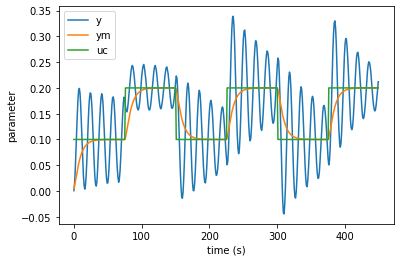

In [5]:
start_idx = 0
end_idx = int(maxt/ts)
plt.plot(tc[start_idx:end_idx], y_list[start_idx:end_idx], label = "y")
plt.plot(tc[start_idx:end_idx], ym_list[start_idx:end_idx], label = "ym")
plt.plot(tc[start_idx:end_idx], uc[start_idx:end_idx], label = "uc")
plt.xlabel("time (s)")
plt.ylabel("parameter")
plt.legend()

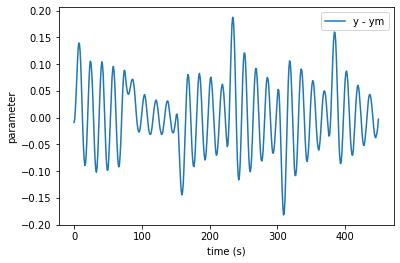

In [400]:
start_idx = 0
end_idx = int(maxt/ts)
#plt.plot(tc[start_idx:end_idx], u_list[start_idx:end_idx], label = "u")
#plt.plot(tc[start_idx:end_idx], ym_list[start_idx:end_idx], label = "ym")
plt.plot(tc[start_idx:end_idx], error_list[start_idx:end_idx], label = "y - ym")
plt.xlabel("time (s)")
plt.ylabel("parameter")
plt.legend()

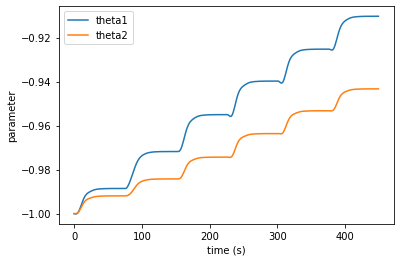

In [401]:
start_idx = 0
end_idx = int(maxt/ts)
#plt.plot(tc[start_idx:end_idx], u_list[start_idx:end_idx], label = "u")
plt.plot(tc[start_idx:end_idx], theta1_list[start_idx:end_idx], label = "theta1")
plt.plot(tc[start_idx:end_idx], theta2_list[start_idx:end_idx], label = "theta2")
plt.xlabel("time (s)")
plt.ylabel("parameter")
plt.legend()

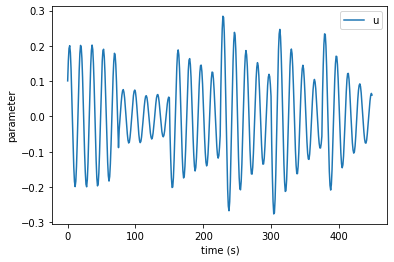

In [402]:
start_idx = 0
end_idx = int(maxt/ts)

plt.plot(tc[start_idx:end_idx], u_list[start_idx:end_idx], label = "u")
plt.xlabel("time (s)")
plt.ylabel("parameter")
plt.legend()

# normalized MIT Rule

In [8]:
i = 0

#system input
uc_i = 1

#initial state of system
y_p1_i = 0
y_i = 0
u_i = 0

#initial state of model
ym_p1_i = 0
ym_i = 0

theta1_p2_i, theta1_p1_i, theta2_p2_i, theta2_p1_i = 0,0,0,0
theta1_p1_n, theta2_p1_n = 0,0
#theta1_i = -(OMEGA**2)/B
#theta2_i = (2*ZETA*OMEGA-B)/B
theta1_i = -1
theta2_i = -1

theta1_n_i = theta1_i/(alpha + theta1_i**2)
theta2_n_i = theta2_i/(alpha + theta2_i**2)

#theta1_i = 0.1
#theta2_i = 0.1


y_list = []
ym_list = []
u_list = []
tc= []
error_list = []

uc = []
for i in range(int(maxt/ts)+1):
    uc.append(u_signal(i*ts))

theta1_list = []
theta2_list = []

i=0
for k in range(n_steps):
    #system
    uc_i = uc[i]
    #uc_i = 9
    system_results = system_sim(y_p1_i,y_i,u_i)
    y_i = system_results["y"]
    y_p1_i = system_results["y_p1"] 
    
    #model
    model_results = system_model(uc_i, ym_p1_i, ym_i)
    ym_p2_i = model_results["ym_p2"]
    ym_p1_i = model_results["ym_p1"]
    ym_i = model_results["ym"]

    adapt_val = Adaptation_Law_Normalized(y_i, ym_i, ym_p1_i, ym_p2_i,
                                     theta1_p2_i, theta1_p1_i, theta1_i,
                                     theta2_p2_i, theta2_p1_i, theta2_i,
                                     theta1_p1_n, theta1_n_i,
                                     theta2_p1_n, theta2_n_i)

    theta1_p2_i, theta1_p1_i, theta1_i = adapt_val["theta1_p2"], adapt_val["theta1_p1"], adapt_val["theta1"]
    theta2_p2_i, theta2_p1_i, theta2_i = adapt_val["theta2_p2"], adapt_val["theta2_p1"], adapt_val["theta2"]
    theta1_p1_n, theta1_n_i = adapt_val["theta1n_p1"], adapt_val["theta1_n"]
    theta2_p1_n, theta2_n_i = adapt_val["theta2n_p1"], adapt_val["theta2_n"]
    
    u_i =  controller(y_i, uc_i, y_p1_i, theta1_n_i, theta2_n_i)
   
    theta1_list.append(theta1_n_i)
    theta2_list.append(theta2_n_i)

    y_list.append(y_i)
    u_list.append(u_i)
    ym_list.append(ym_i)
    error_list.append(y_i-ym_i)
    
    tc.append(i*ts)
    i = i+1
print("normalized MIT Rule Simulation Complete")


normalized MIT Rule Simulation Complete


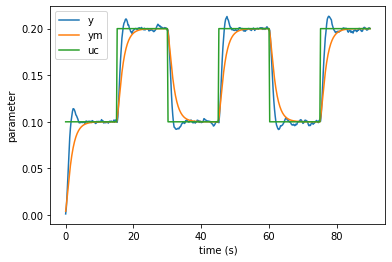

In [9]:
start_idx = 0
end_idx = int(maxt/ts)
plt.plot(tc[start_idx:end_idx], y_list[start_idx:end_idx], label = "y")
plt.plot(tc[start_idx:end_idx], ym_list[start_idx:end_idx], label = "ym")
plt.plot(tc[start_idx:end_idx], uc[start_idx:end_idx], label = "uc")
plt.xlabel("time (s)")
plt.ylabel("parameter")
plt.legend()

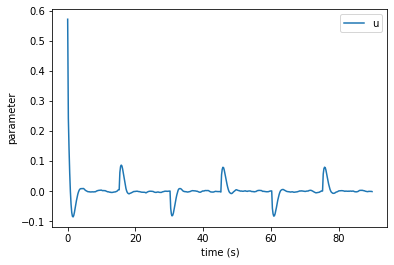

In [405]:
start_idx = 0
end_idx = int(maxt/ts)

plt.plot(tc[start_idx:end_idx], u_list[start_idx:end_idx], label = "u")
plt.xlabel("time (s)")
plt.ylabel("parameter")
plt.legend()

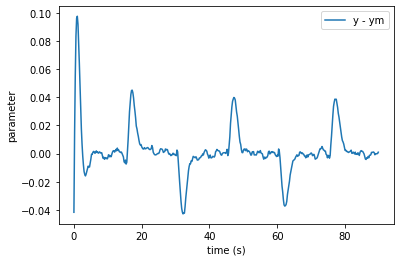

In [406]:
start_idx = 0
end_idx = int(maxt/ts)
#plt.plot(tc[start_idx:end_idx], u_list[start_idx:end_idx], label = "u")
#plt.plot(tc[start_idx:end_idx], ym_list[start_idx:end_idx], label = "ym")
plt.plot(tc[start_idx:end_idx], error_list[start_idx:end_idx], label = "y - ym")
plt.xlabel("time (s)")
plt.ylabel("parameter")
plt.legend()

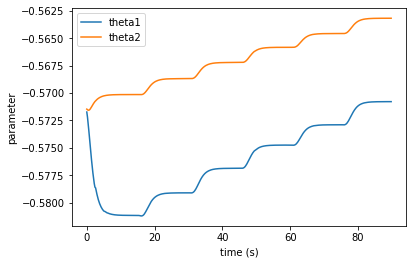

In [407]:
start_idx = 0
end_idx = int(maxt/ts)
#plt.plot(tc[start_idx:end_idx], u_list[start_idx:end_idx], label = "u")
plt.plot(tc[start_idx:end_idx], theta1_list[start_idx:end_idx], label = "theta1")
plt.plot(tc[start_idx:end_idx], theta2_list[start_idx:end_idx], label = "theta2")
plt.xlabel("time (s)")
plt.ylabel("parameter")
plt.legend()